# FFNN + MNIST
Purpose: Fit a Standard Dense Network (FFNN) to the MNIST dataset. The purpose is to establish a baseline for the MNIST experiments.

This is the Accuracy variant, which means it seeks to find the highest performance using as much of the dataset as possible, while balancing the parameter count.

Furthermore, the PyTorch Lightning library is used for convenience.

In [1]:
# Imports
import numpy as np
import pandas as pd
import torch
from torch import nn
import lightning as L
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import transforms
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
import matplotlib.pyplot as plt

# Setup Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Setup Randomness -- https://lightning.ai/docs/pytorch/stable/common/trainer.html
L.seed_everything(68812, workers=True) # <--- Adjust the seed here for each trial run for the 5 seed values [42, 998244353, 10122024, 1000000007, 68812].

# CUDA Efficiency
if torch.cuda.is_available():
    torch.set_float32_matmul_precision('high')
    print("Configured CUDA Precision")

Seed set to 68812


Configured CUDA Precision


In [2]:
# Dataset Setup -- Inspired by Hugo's Dataset Reformatting
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = MNIST("./Experiments/temp/", train=True, download=True, transform=transform)
test_dataset = MNIST("./Experiments/temp/", train=False, download=True, transform=transform)

train_size = int(len(train_dataset) * 0.99)
val_size = int(len(train_dataset)) - train_size # Quite low validation size, but this is done to allow for greater model accuracy.
train_set, val_set = random_split(train_dataset, [train_size, val_size])

# Reformatted, due to odd issues when using NTK on it
class LCDataset(Dataset): # Lightning Compatible Dataset
    def __init__(self, dataset, num_classes, limit=-1):
        self.limit = limit
        self.num_classes = num_classes
        if self.limit != -1:
            sub = list(np.random.permutation(np.arange(len(train_dataset)))[0:self.limit]) # Take a random sample of the first some elements.
            self.dataset = Subset(dataset, sub)
        else:
            self.dataset = dataset
    
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x, y = self.dataset[idx]
        y_one_hot = torch.zeros(self.num_classes)
        y_one_hot[y] = 1
        return x, y_one_hot

batch_size = 64
train_loader = DataLoader(LCDataset(train_set, num_classes=10), batch_size=batch_size, shuffle=True, num_workers=10)
val_loader = DataLoader(LCDataset(val_set, num_classes=10), batch_size=batch_size, shuffle=False, num_workers=10)
test_loader = DataLoader(LCDataset(test_dataset, num_classes=10), batch_size=batch_size, num_workers=10)

In [3]:
# Model Declaration
class ClassicFFNN(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.BatchNorm2d(1),
            nn.MaxPool2d(2),
            nn.Flatten(1),
            nn.Linear(14*14, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )
    
    def forward(self, x):
        return self.net(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = F.cross_entropy(y_pred, y) # MSE Loss works better for NTK
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        v1 = torch.argmax(y_pred, dim=1)
        v2 = torch.argmax(y, dim=1)
        loss = F.cross_entropy(y_pred, y) # MSE Loss works better for NTK
        accuracy = torch.sum(torch.eq(v1, v2)) / len(y)
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", accuracy, prog_bar=True) # Observe model accuracy with time

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        v1 = torch.argmax(y_pred, dim=1)
        v2 = torch.argmax(y, dim=1)
        accuracy = torch.sum(torch.eq(v1, v2)) / len(y)
        self.log("accuracy", accuracy) # Accuracy for Accuracy vs. Parameter Experiment

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        return self(batch)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=2e-4, weight_decay=2e-3)
        return optimizer

In [4]:
# Train + Test + Results
model = ClassicFFNN()
trained_model = L.Trainer(max_epochs=100, deterministic=True, logger=CSVLogger(save_dir="Experiments/logs", name="MNISTFFNNAcc", version="fin"), callbacks=[EarlyStopping(monitor="val_loss", mode="min", patience=10)])
trained_model.fit(model, train_loader, val_loader)
trained_model.test(model, test_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 13.3 K | train
--------------------------------------------
13.3 K    Trainable params
0         Non-trainable params
13.3 K    Total params
0.053     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         accuracy          │    0.9739000201225281     │
└───────────────────────────┴───────────────────────────┘

[{'accuracy': 0.9739000201225281}]

In [5]:
logdata = pd.read_csv("Experiments/logs/MNISTFFNNAcc/fin/metrics.csv")

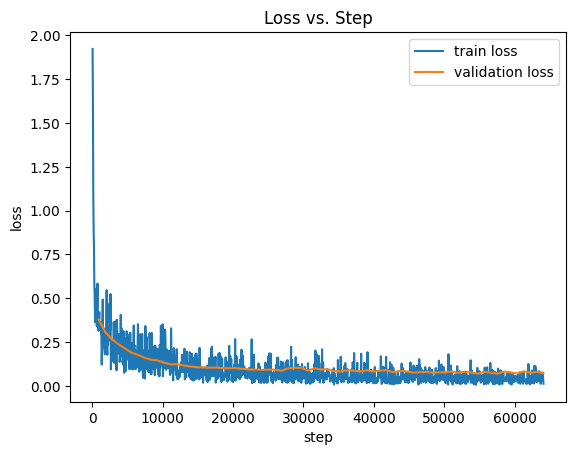

In [6]:
traindeflog = logdata.loc[logdata['train_loss'].notna(), ['step', 'train_loss']]
valdeflog = logdata.loc[logdata['val_loss'].notna(), ['step', 'val_loss']]
fig, ax = plt.subplots()
ax.plot(traindeflog['step'], traindeflog['train_loss'], label="train loss")
ax.plot(valdeflog['step'], valdeflog['val_loss'], label="validation loss")
ax.set(xlabel="step", ylabel="loss", title="Loss vs. Step")
plt.legend(loc="upper right")
plt.show()

In [7]:
# R: True Value, C: Predicted Value
def make_predict_matrix(model, dataloader):
    res = np.zeros(shape=(10, 10), dtype=int)
    model = model.to(device)
    for it in iter(dataloader):
        x, y = it
        x = x.to(device)
        y = y.to(device)
        x_arg = torch.argmax(model.forward(x), dim=1)
        y_arg = torch.argmax(y, dim=1)
        for i in range(len(x_arg)):
            res[y_arg[i], x_arg[i]] += 1
    return res

In [8]:
print(make_predict_matrix(model, test_loader))

[[ 968    0    0    2    2    3    1    2    1    1]
 [   0 1126    4    0    0    0    2    1    2    0]
 [   6    1 1007    3    2    0    2    4    7    0]
 [   1    1    5  978    0    3    0    6   11    5]
 [   2    0    3    0  969    0    0    2    2    4]
 [   3    1    0   17    2  854    2    0   11    2]
 [   9    5    1    1    6    2  926    0    8    0]
 [   0    2   14    2    2    0    0  998    1    9]
 [   8    1    7    5    3    2    1    3  942    2]
 [   0    6    1   11   15    4    1    6    4  961]]
